In [11]:
import multiprocessing as mp 

from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from jax.tree_util import tree_flatten_with_path, GetAttrKey, DictKey, SequenceKey

import matplotlib.pyplot as plt
import pandas as pd
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb

from foundational_ssm.samplers import RandomVariableWindowSampler 
from foundational_ssm.constants import DATA_ROOT 
from foundational_ssm.loaders import get_brainset_data_loader
from foundational_ssm.utils.training_utils import create_optimizer_and_state

mp.set_start_method("spawn", force=True) # otherwise causes deadlock on jax.

%load_ext autoreload
%autoreload 2


def mse_single_sample_foundation(model, state, input, target, mask, dataset_group_idxs, key, dataset_group_weights=None, skip_timesteps=0):
    """MSE loss for foundational model (takes dataset_group_idx and mask)"""
    pred, state = model(input, state, dataset_group_idxs, key)

    # Only evaluate loss on timesteps > skip_timesteps
    pred = pred[skip_timesteps:, :]  # Shape: (batch, seq_len - skip_timesteps, output_dim)
    target = target[skip_timesteps:, :]  # Shape: (batch, seq_len - skip_timesteps, output_dim)
    mask = mask[skip_timesteps:]  # Shape: (batch, seq_len - skip_timesteps)

    # Only compute loss on unmasked elements
    squared_error = (pred - target) ** 2
    mask = mask[..., None]
    masked_squared_error = jnp.where(mask, squared_error, 0.0)
    
    # dataset_group_weights = dataset_group_weights[..., None, None]  # shape (batch, 1, 1) to broadcast
    weighted_squared_error = squared_error #* dataset_group_weights
        
    masked_squared_error = jnp.where(mask, weighted_squared_error, 0.0)
    mse = masked_squared_error.sum() / mask.sum()
    return mse


def _path_to_str(path):
    parts = []
    for entry in path:
        if isinstance(entry, GetAttrKey):
            parts.append(str(entry.name))
        elif isinstance(entry, DictKey):
            parts.append(str(entry.key))
        elif isinstance(entry, SequenceKey):
            parts.append(f"[{entry.idx}]")
        else:
            parts.append(str(entry))
    return ".".join(parts)

def _stack_weighted_grads_to_matrix(grads_batch_tree, lr_leaves):
    """Return a dict of per-leaf weighted, flattened gradients keyed by leaf path.

    grads_batch_tree: PyTree of per-sample gradients; each array leaf has shape (N, ...).
    lr_leaves: list of scalars aligned with the flattened leaf order.
    Returns: dict[str, jnp.ndarray] mapping leaf path -> (N, leaf_size) matrix, weighted by sqrt(lr).
    """
    # Filter non-array leaves, keeping structure for alignment
    filtered = eqx.filter(grads_batch_tree, eqx.is_array)
    path_leaves, _ = tree_flatten_with_path(filtered)
    out = {}
    i = 0
    for path, leaf in path_leaves:
        if leaf is None:
            continue
        g2d = jnp.reshape(leaf, (leaf.shape[0], -1))
        lr_scalar = lr_leaves[i]
        out[_path_to_str(path)] = g2d * jnp.sqrt(lr_scalar)
        i += 1
    return out

def _dicts_to_matrix(dict_list):
    """Concatenate per-leaf dicts into a single matrix.

    - Uses a stable sorted key order from the first dict.
    - Horizontally concatenates leaves per sample, then vertically stacks across dicts.
    """
    if not dict_list:
        return jnp.zeros((0, 0))
    keys = sorted(dict_list[0].keys())
    row_blocks = []
    for d in dict_list:
        if not keys:
            return jnp.zeros((d[next(iter(d))].shape[0], 0)) if d else jnp.zeros((0, 0))
        row_blocks.append(jnp.concatenate([d[k] for k in keys], axis=1))
    return jnp.concatenate(row_blocks, axis=0)

def stack_dicts(dict_list):
    """Stack a list of dicts (per-batch) into a single dict of stacked arrays keyed by leaf path.

    Args:
        dict_list (list): list of dicts each containing array leaves with leading batch dim.

    Returns:
        dict mapping canonical leaf path (str) -> array of shape (sum_batches, leaf_size...)
    """
    if not dict_list:
        return {}
    keys = sorted(dict_list[0].keys())
    stacked = {k: jnp.concatenate([d[k] for d in dict_list], axis=0) for k in keys}
    return stacked

def stack_trees_to_dict(tree_list, flatten=True):
    """Stack a list of PyTrees (per-batch) into a dict of stacked arrays keyed by leaf path.

    Args:
        tree_list (list): list of PyTrees each containing array leaves with leading batch dim.
        flatten (bool): whether to reshape leaves to (batch, -1) before stacking.

    Returns:
        dict mapping canonical leaf path (str) -> array of shape (sum_batches, leaf_size...)

    Notes: Requires that all trees have the same leaf paths; raises ValueError otherwise.
    """
    if not tree_list:
        return {}
    dicts = []
    for tree in tree_list:
        filtered = eqx.filter(tree, eqx.is_array)
        path_leaves, _ = tree_flatten_with_path(filtered)
        d = {}
        for path, leaf in path_leaves:
            if leaf is None:
                continue
            if flatten:
                d[_path_to_str(path)] = jnp.reshape(leaf, (leaf.shape[0], -1))
            else:
                d[_path_to_str(path)] = leaf
        dicts.append(d)
    return stack_dicts(dicts)


def stack_trees_to_matrix(tree_list, flatten=True):
    """Convert a list of PyTrees into a single matrix by stacking leaves horizontally then samples vertically.

    This is useful for building G matrices for NTK or activation similarity computations.
    """
    stacked = stack_trees_to_dict(tree_list, flatten=flatten)
    if not stacked:
        return jnp.zeros((0, 0))
    keys = sorted(stacked.keys())
    return jnp.concatenate([stacked[k] for k in keys], axis=1)

def compute_kernel_similarity(K_1, K_2):
    """Compute similarity between two kernel matrices using Frobenius inner product."""
    frob_inner_product = np.sum(K_1 * K_2)
    frob_norm_1 = np.sqrt(np.sum(K_1 ** 2))
    frob_norm_2 = np.sqrt(np.sum(K_2 ** 2))
    similarity = 1 - frob_inner_product / (frob_norm_1 * frob_norm_2)
    return similarity

def compute_per_leaf_kernel_similarity(dict_a, dict_b):
    """Given two stacked dicts (key -> (N, D) array), compute per-leaf kernel similarity.

    Returns a dict key->scalar where scalar is the same metric used by compute_kernel_similarity
    applied to K_a = A @ A.T and K_b = B @ B.T.
    """
    keys = sorted(set(dict_a.keys()) & set(dict_b.keys()))
    out = {}
    for k in keys:
        A = dict_a[k]
        B = dict_b[k]
        # Ensure same shapes
        if A.shape[0] != B.shape[0]:
            raise ValueError(f"Batch sizes differ for leaf {k}: {A.shape[0]} vs {B.shape[0]}")
        K_a = A @ A.T
        K_b = B @ B.T
        out[k] = compute_kernel_similarity(K_a, K_b)
    return out

def compute_per_leaf_cosine_similarity(dict_a, dict_b):
    """Compute per-leaf cosine similarity by vectorizing each stacked array and computing cosine(v_a, v_b).

    Returns dict key -> cosine scalar in [-1,1]. If vectors are zero, returns 0.
    """
    keys = sorted(set(dict_a.keys()) & set(dict_b.keys()))
    out = {}
    for k in keys:
        A = dict_a[k]
        B = dict_b[k]
        if A.shape != B.shape:
            raise ValueError(f"Shapes differ for leaf {k}: {A.shape} vs {B.shape}")
        va = A.ravel()
        vb = B.ravel()
        na = np.linalg.norm(va)
        nb = np.linalg.norm(vb)
        if na == 0 or nb == 0:
            out[k] = 0.0
        else:
            inner = np.vdot(va, vb)
            cos_val = np.real(inner / (na * nb))  # use real part; or use np.abs(...) for magnitude
            out[k] = 1 - cos_val
    return out

def get_per_leaf_metadata_from_trees(tree_list):
    """Return dict key -> { 'shape': leaf_shape_without_batch, 'dtype': dtype } from the first tree in the list."""
    if not tree_list:
        return {}
    filtered = eqx.filter(tree_list[0], eqx.is_array)
    path_leaves, _ = tree_flatten_with_path(filtered)
    out = {}
    for path, leaf in path_leaves:
        if leaf is None:
            continue
        out[_path_to_str(path)] = {
            'shape': tuple(leaf.shape[1:]),
            'dtype': str(leaf.dtype),
        }
    return out

def mse_single_sample_downstream(model, state, input, target, mask, key, dataset_group_weights=None, skip_timesteps=0):
    """MSE loss for foundational model (takes dataset_group_idx and mask)"""
    pred, state = model(input, state, key)

    # Only evaluate loss on timesteps > skip_timesteps
    pred = pred[skip_timesteps:, :]  # Shape: (batch, seq_len - skip_timesteps, output_dim)
    target = target[skip_timesteps:, :]  # Shape: (batch, seq_len - skip_timesteps, output_dim)
    mask = mask[skip_timesteps:]  # Shape: (batch, seq_len - skip_timesteps)

    # Only compute loss on unmasked elements
    squared_error = (pred - target) ** 2
    mask = mask[..., None]
    masked_squared_error = jnp.where(mask, squared_error, 0.0)
    
    # dataset_group_weights = dataset_group_weights[..., None, None]  # shape (batch, 1, 1) to broadcast
    weighted_squared_error = squared_error #* dataset_group_weights
        
    masked_squared_error = jnp.where(mask, weighted_squared_error, 0.0)
    mse = masked_squared_error.sum() / mask.sum()
    return mse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataset, loader, max_neural_input = get_brainset_data_loader(    
    dataset_args = {
        'keep_files_open': False,
        'lazy': True,
        'config': '/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/dataset/reaching_analysis.yaml'
    },
    dataloader_args={
        'batch_size': 16,
        'num_workers': 2,
        'persistent_workers': True,
    },
    sampler = 'TrialSampler',
    sampler_args = {
        'max_window_length': 5.0
    },
    data_root = '../' + DATA_ROOT,
    prepend_history = 0.3,
    sampling_rate = 200,
    split = 'train_trial_subsample'
 )


In [5]:
# Collect gradients and activations eqx.nn.inference_mode 
from tqdm import tqdm


layers = [2,4]
skip_timesteps = 0.3 * 200
model_cls = SSMFoundationalDecoder
models = {}
results = []
G_list = [] 
A_list = []
loss_fn = mse_single_sample_foundation 
epochs = list(range(0,501,100))
layer_keys = ["post_encoder","ssm_x", "ssm_y", "ssm_post_gelu", "ssm_post_glu", "pre_decoder"] 

for l in layers:
    checkpoint_name = f'melinajingting-ucl/foundational_ssm_pretrain/l{l}_reaching_normalized_checkpoint'
    model_cfg = OmegaConf.load(f'/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/model/l{l}.yaml')
    for epoch in epochs:
        artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
        model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
        models.update({
            f'epoch {epoch}':model
        })  
        
        inf_model = eqx.nn.inference_mode(model)
        grads_list = []
        activations_list = []
        for batch in loader:
            batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
            inputs = batch["neural_input"]
            targets = batch["behavior_input"]
            mask = batch["mask"]
            dataset_group_idxs = batch["dataset_group_idx"]

            grads = jax.vmap(eqx.filter_grad(loss_fn), in_axes=(None, None, 0, 0, 0, 0, None, None), axis_name='batch')(model, state, inputs, targets, mask, dataset_group_idxs, jr.PRNGKey(0), skip_timesteps)
            grads_list.append(grads)

            _, _, activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, 0, None))(inputs, state, dataset_group_idxs, layer_keys)
            activations_list.append(activations)

        opt, opt_state, lr_scheduler, lr_tree = create_optimizer_and_state(model, optimizer_cfg=model_cfg.optimizer, model_cfg=model_cfg.model, return_lr_tree=True)
        lr_leaves = [leaf for leaf in jax.tree_util.tree_leaves(eqx.filter(lr_tree, eqx.is_array)) if leaf is not None]
        
        G_dict = stack_trees_to_dict(grads_list, flatten=True)
        G_dict = jax.device_get(G_dict)           # moves whole PyTree to host
        G_dict = {k: np.asarray(v) for k, v in G_dict.items()}

        A_dict = stack_dicts(activations_list)
        A_dict = jax.device_get(A_dict)
        A_dict = {k: np.asarray(v) for k, v in A_dict.items()}

        if epoch == 0:
            G_dict_0 = G_dict
            A_dict_0 = A_dict
        G_list.append(G_dict)
        A_list.append(A_dict)
        
        kernel_similarity = compute_per_leaf_kernel_similarity(G_dict, G_dict_0)
        activation_similarity = compute_per_leaf_cosine_similarity(A_dict, A_dict_0)
        _results = {
            'l': l,
            'epoch': epoch,
        }
        _results.update(kernel_similarity)
        _results.update(activation_similarity)
        results.append(_results)
        

# fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(np.array(S), vmax=1, vmin=0)
# fig.colorbar(im, ax=ax)
# ax.set_title('NTK Matrix similarity across epochs in pretraining')
# # Set ticks and labels from `epochs`
# ax.set_xticks(list(range(len(epochs))))
# ax.set_yticks(list(range(len(epochs))))
# ax.set_xticklabels([str(e) for e in epochs])
# ax.set_yticklabels([str(e) for e in epochs])
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Epoch')
# plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# fig.tight_layout()

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  
/tmp/ipykernel_59761/3712060952.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.01, 'output_dim': 2, 'ssm_io_dim': 512, 'ssm_num_layers': 4, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l4.yaml', 'optimizer': {'lr': 0.001, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixedWindowSampler', 'datase

wandb: Downloading large artifact l4_reaching_normalized_checkpoint:epoch_0, 66.53MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5 (143.6MB/s)
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5 (143.6MB/s)
2025-08-26 11:11:59.163569: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 239.81MiB (rounded to 251460096)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-26 11:11:59.167235: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************************************************************************************
E0826 11:11:59.167275   59761 pjrt_stream_executor_client.cc:2939] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 251460000 bytes. [tf-allocator-allocatio

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 251460000 bytes.

Index(['l', 'epoch', 'context_embedding.weight', 'decoder.bias',
       'decoder.weight', 'encoders.[0].bias', 'encoders.[0].weight',
       'encoders.[1].bias', 'encoders.[1].weight', 'encoders.[2].bias',
       'encoders.[2].weight', 'encoders.[3].bias', 'encoders.[3].weight',
       'encoders.[4].bias', 'encoders.[4].weight', 'encoders.[5].bias',
       'encoders.[5].weight', 'encoders.[6].bias', 'encoders.[6].weight',
       'encoders.[7].bias', 'encoders.[7].weight', 'encoders.[8].bias',
       'encoders.[8].weight', 'encoders.[9].bias', 'encoders.[9].weight',
       'ssm_blocks.[0].glu.w1.bias', 'ssm_blocks.[0].glu.w1.weight',
       'ssm_blocks.[0].glu.w2.bias', 'ssm_blocks.[0].glu.w2.weight',
       'ssm_blocks.[0].ssm.B', 'ssm_blocks.[0].ssm.C', 'ssm_blocks.[0].ssm.D',
       'ssm_blocks.[0].ssm.Lambda_im', 'ssm_blocks.[0].ssm.Lambda_re',
       'ssm_blocks.[0].ssm.log_step', 'ssm_blocks.[1].glu.w1.bias',
       'ssm_blocks.[1].glu.w1.weight', 'ssm_blocks.[1].glu.w2.bias',
   

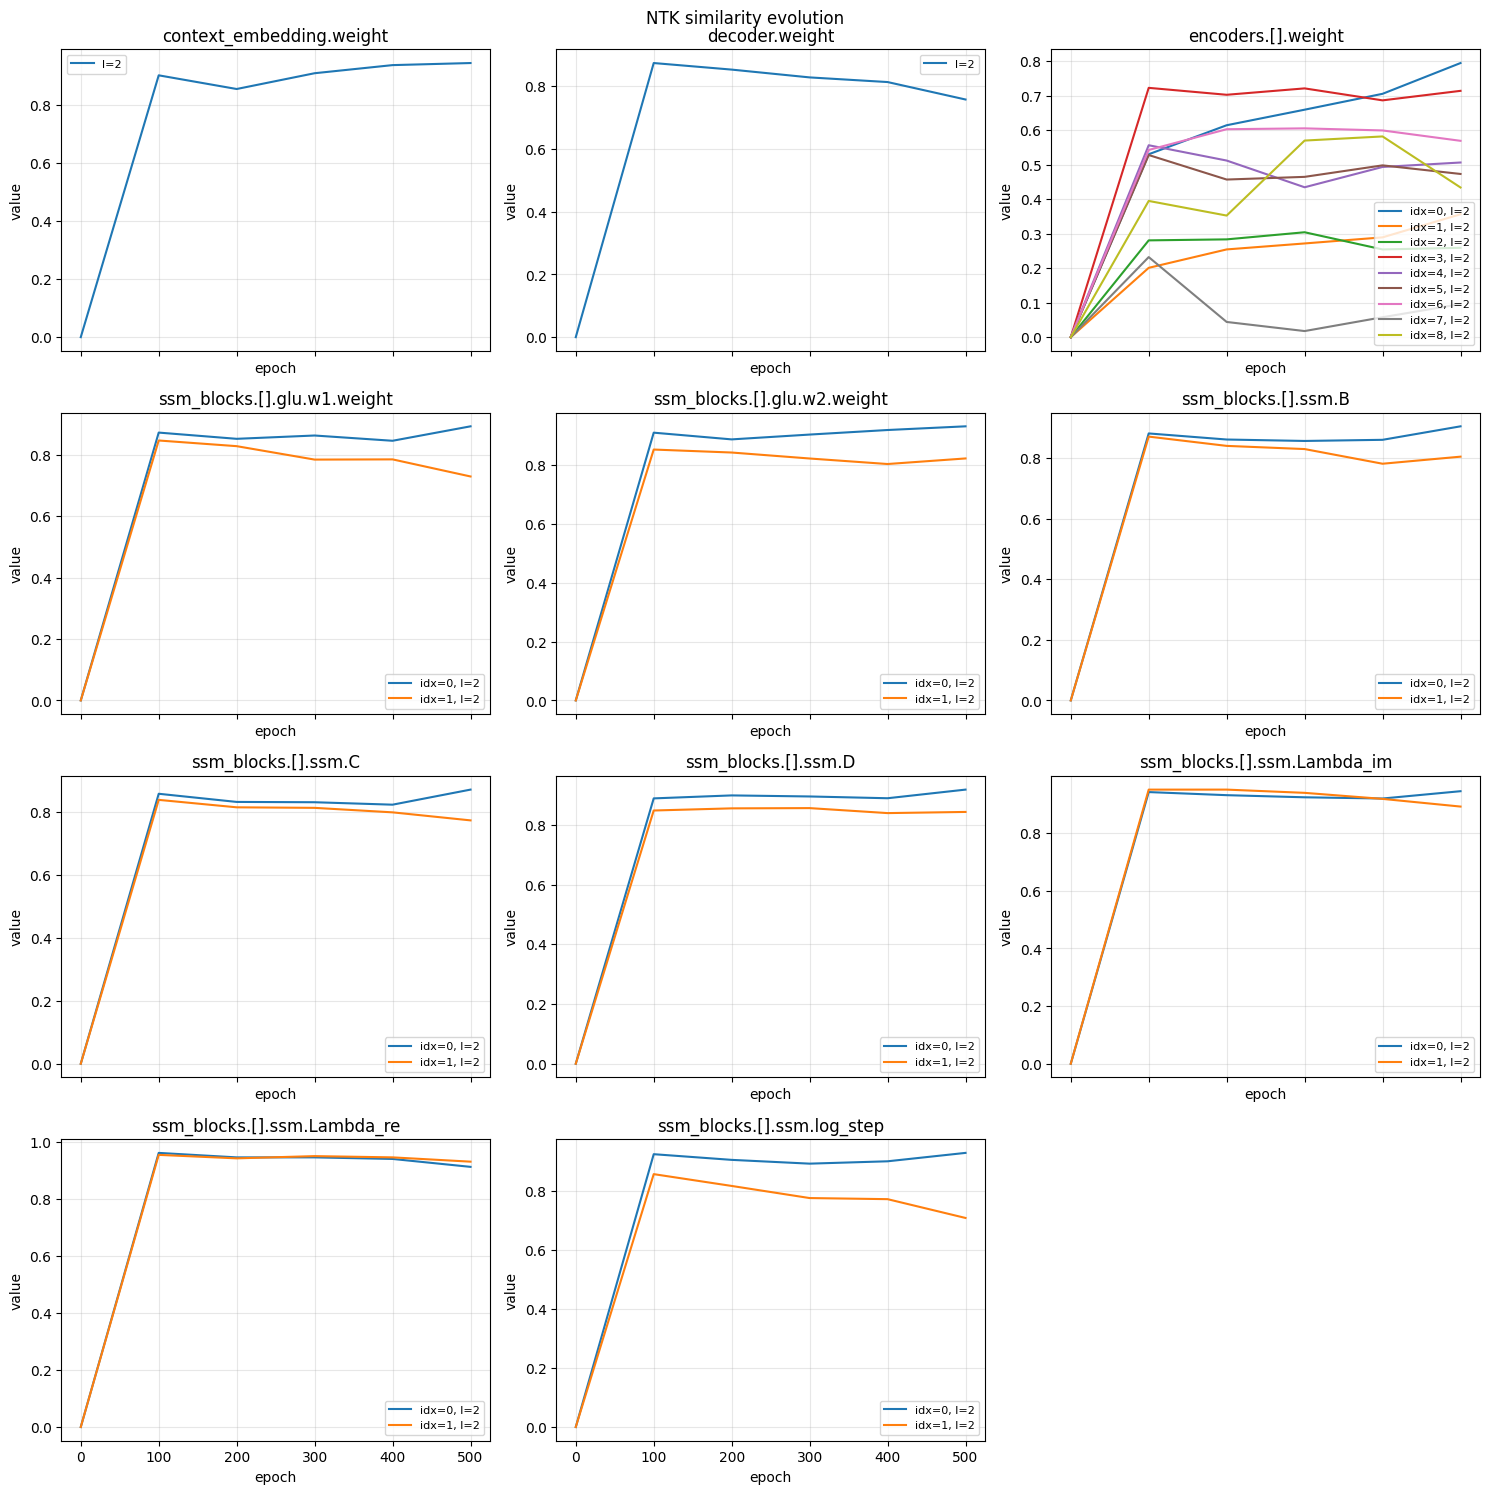

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


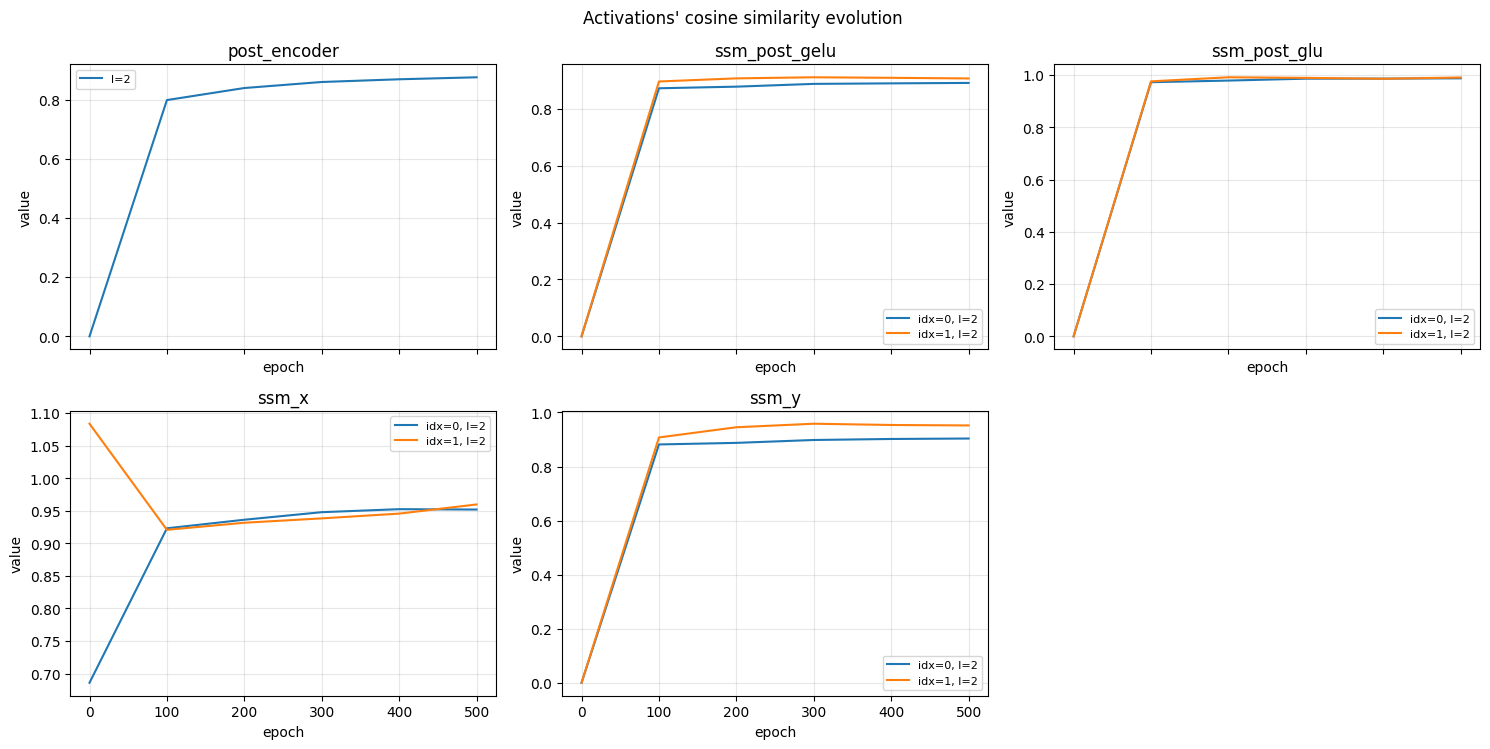

In [18]:
import re, math
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results)
results_df.keys()

df = results_df.copy()

# Identify columns
meta_cols = {'l','epoch'}
all_cols = [c for c in df.columns if c not in meta_cols]
kernel_cols = [c for c in all_cols if ('.' in c) and ('bias' not in c)]
activation_cols = [c for c in all_cols if '.' not in c]

def kernel_base(col):
    return re.sub(r"\[\d+\]", "[]", col)

kernel_groups = {}  # base -> list of (col, idx_label)
for c in kernel_cols:
    base = kernel_base(c)
    # Collect all numeric indices that appear in path (could be multiple levels); build a compact label
    idxs = re.findall(r"\[(\d+)\]", c)
    idx_label = ",".join(idxs) if idxs else None
    kernel_groups.setdefault(base, []).append((c, idx_label))

# Group activation columns by base component: treat trailing _<int> as index; otherwise no index
activation_groups = {}  # base -> list of (col, idx_label)
for c in activation_cols:
    m = re.match(r"^(.*)_(\d+)$", c)
    if m:
        base, idx = m.group(1), m.group(2)
        activation_groups.setdefault(base, []).append((c, idx))
    else:
        activation_groups.setdefault(c, []).append((c, None))

def plot_groups(df, groups, title):
    bases = list(groups.keys())
    if not bases:
        print(f"No groups to plot for {title}.")
        return
    n = len(bases)
    ncols = 3 if n >= 3 else n
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.8*nrows), squeeze=False, sharex=True)
    l_values = sorted(df['l'].unique())
    for i, base in enumerate(bases):
        r, c = divmod(i, ncols)
        ax = axes[r][c]
        for col, idx_label in groups[base]:
            # For each layer l, plot line
            for lval in l_values:
                sub = df[df['l'] == lval][['epoch', col]].dropna().sort_values('epoch')
                if sub.empty:
                    continue
                label_parts = []
                if idx_label is not None:
                    label_parts.append(f"idx={idx_label}")
                label_parts.append(f"l={lval}")
                ax.plot(sub['epoch'].values, sub[col].values, label=", ".join(label_parts))
        ax.set_title(base)
        ax.set_xlabel('epoch')
        ax.set_ylabel('value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8, loc='best')
    # Hide any unused axes
    for j in range(i+1, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis('off')
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Plot figures
plot_groups(df, kernel_groups, title='NTK similarity evolution')
plot_groups(df, activation_groups, title="Activations' cosine similarity evolution ")

In [ ]:
norms_titles = {
    'encoder': {
        'activations': 'post_encoder',
        'gradients': 
    }
    
    'post_encoder_norm': r' $\frac{\|x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_norm': r' $\frac{\|x^{(0)}\|}{\sqrt{D_{x}}}$',
    'ssm_y_0_norm': r' $\frac{\|y^{(0)}\|}{\sqrt{D_{u}}}$',
    'ssm_post_gelu_0_norm': r' $\frac{\|x_{gelu}\|}{\sqrt{D_{u}}}$',
    'ssm_post_glu_0_norm': r' $\frac{\|x_{glu}\|}{\sqrt{D_{u}}}$',
    'output_norm': r' $\frac{\|y_{out}\|}{\sqrt{D_{u}}}$',
    'post_encoder_diff_norm': r' $\frac{\|\Delta x_{enc}\|}{\sqrt{D_{enc}}}$',
    'ssm_x_0_diff_norm': r' $\frac{\|\Delta x\|}{\sqrt{D_{x}}}$',
    'ssm_y_0_diff_norm': r' $\frac{\|\Delta y\|}{\sqrt{D_{u}}}$',
    'ssm_post_gelu_0_diff_norm': r' $\frac{\|\Delta x_{gelu}\|}{\sqrt{D_{u}}}$',
    'ssm_post_glu_0_diff_norm': r' $\frac{\|\Delta x_{glu}\|}{\sqrt{D_{u}}}$',
    'output_diff_norm': r' $\frac{\|\Delta y_{out}\|}{\sqrt{D_{u}}}$'
}

3

In [4]:
results_df = pd.DataFrame(results)

[{'kernel_similarity': {'context_embedding.weight': Array(0., dtype=float32),
   'decoder.bias': Array(0., dtype=float32),
   'decoder.weight': Array(5.9604645e-08, dtype=float32),
   'encoders.[0].bias': Array(5.9604645e-08, dtype=float32),
   'encoders.[0].weight': Array(0., dtype=float32),
   'encoders.[1].bias': Array(0., dtype=float32),
   'encoders.[1].weight': Array(5.9604645e-08, dtype=float32),
   'encoders.[2].bias': Array(5.9604645e-08, dtype=float32),
   'encoders.[2].weight': Array(0., dtype=float32),
   'encoders.[3].bias': Array(5.9604645e-08, dtype=float32),
   'encoders.[3].weight': Array(5.9604645e-08, dtype=float32),
   'encoders.[4].bias': Array(nan, dtype=float32),
   'encoders.[4].weight': Array(nan, dtype=float32),
   'encoders.[5].bias': Array(nan, dtype=float32),
   'encoders.[5].weight': Array(nan, dtype=float32),
   'encoders.[6].bias': Array(nan, dtype=float32),
   'encoders.[6].weight': Array(nan, dtype=float32),
   'encoders.[7].bias': Array(0., dtype=floa

In [10]:
dict1['encoders.[0].weight'].shape

(5, 252, 625)

In [ ]:
cfg = OmegaConf.create({
                        'model':{
                            'input_dim': 621,
                            'context_dim': 4,
                            'ssm_io_dim': 256,
                            'ssm_dim': 128,
                            'ssm_init_diag_blocks': 4,
                            'ssm_num_layers': 2,
                            'output_dim': 2,
                            'rng_seed': 42,
                            'dt_min': 0.001,
                            'dt_max': 0.01,
                            'dropout_p': 0.03,
                            'ssm_dropout_p': 0.01
                        },
                        'optimizer':{
                            'lr': 0.002,
                            'weight_decay': 0.01,
                            'mode': 'all'
                        }
                    })

# Downstream task

In [ ]:
# Collect gradients and activations eqx.nn.inference_mode 
from tqdm import tqdm
from foundational_ssm.utils.downstream_utils import get_rtt_datasets

cfg = OmegaConf.create({
                        'model':{
                            'input_dim': 72,
                            'context_dim': 4,
                            'ssm_io_dim': 256,
                            'ssm_dim': 128,
                            'ssm_init_diag_blocks': 4,
                            'ssm_num_layers': 2,
                            'output_dim': 2,
                            'rng_seed': 42,
                            'dt_min': 0.001,
                            'dt_max': 0.01,
                            'dropout_p': 0.03,
                            'ssm_dropout_p': 0.01
                        },
                        'optimizer':{
                            'lr': 0.002,
                            'weight_decay': 0.01,
                            'mode': 'all'
                        }
                    })

dataset_cfg = OmegaConf.create({
    'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5',
    'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5',
    'batch_size': 64,
    'phase': 'test',
    'skip_timesteps': 56
})
train_data, val_data, data = get_rtt_datasets(dataset_cfg, jr.PRNGKey(0))
loss_fn = mse_single_sample_downstream 

model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_scratch_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


  0%|          | 0/6 [00:00<?, ?it/s]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 6/6 [00:18<00:00,  3.05s/it]


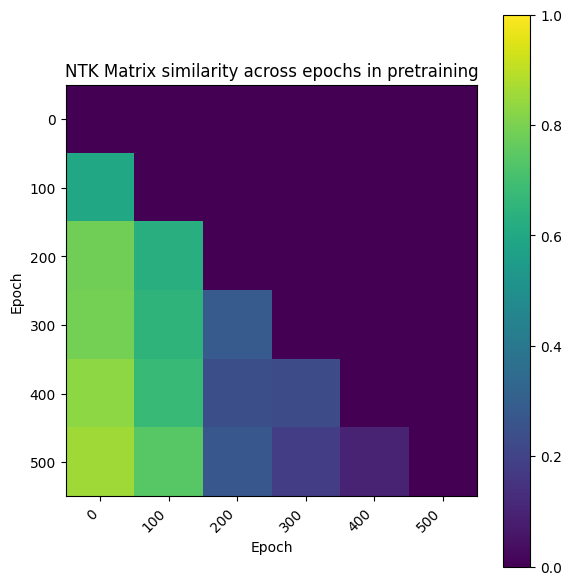

In [ ]:
train_trial_subset = {k: v[1:64] for k, v in train_data.items()}
K_w_list = [] 
S = []
for epoch, model in tqdm(models.items()):
    inf_model = eqx.nn.inference_mode(model)
    grads_list = []
    batch = train_trial_subset
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    dataset_group_idxs = batch["dataset_group_idx"]

    grads = jax.vmap(eqx.filter_grad(loss_fn), in_axes=(None, None, 0, 0, 0, None, None), axis_name='batch')(model, state, inputs, targets, mask, jr.PRNGKey(0), skip_timesteps)
    grads_list.append(grads)

    opt, opt_state, lr_scheduler, lr_tree = create_optimizer_and_state(model, optimizer_cfg=cfg.optimizer, model_cfg=cfg.model, return_lr_tree=True)
    lr_leaves = [leaf for leaf in jax.tree_util.tree_leaves(eqx.filter(lr_tree, eqx.is_array)) if leaf is not None]
    dicts = [_stack_weighted_grads_to_matrix(g, lr_leaves) for g in grads_list]
    G_w = _dicts_to_matrix(dicts)
    K_w = G_w @ G_w.T
    K_w_list.append(K_w)

S = []
for i, K_w in enumerate(K_w_list):
    _S = []
    for j, K_w2 in enumerate(K_w_list):
        if i >= j:
            _S.append(compute_kernel_similarity(K_w, K_w2))
        else:
            _S.append(0)
    S.append(_S)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(np.array(S), vmax=1, vmin=0)
fig.colorbar(im, ax=ax)
ax.set_title('NTK Matrix similarity across epochs in pretraining')
# Set ticks and labels from `epochs`
ax.set_xticks(list(range(len(epochs))))
ax.set_yticks(list(range(len(epochs))))
ax.set_xticklabels([str(e) for e in epochs])
ax.set_yticklabels([str(e) for e in epochs])
ax.set_xlabel('Epoch')
ax.set_ylabel('Epoch')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()

# In finetuning

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  
  0%|          | 0/6 [00:00<?, ?it/s]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


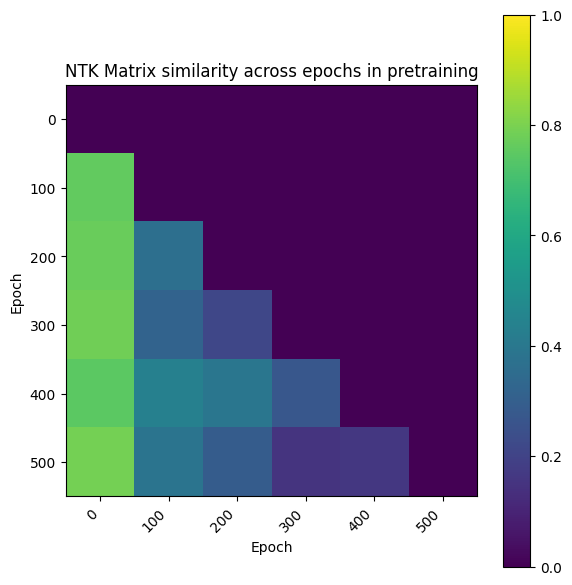

In [ ]:
# Collect gradients and activations eqx.nn.inference_mode 
from tqdm import tqdm
from foundational_ssm.utils.downstream_utils import get_rtt_datasets

cfg = OmegaConf.create({
                        'model':{
                            'input_dim': 72,
                            'context_dim': 4,
                            'ssm_io_dim': 256,
                            'ssm_dim': 128,
                            'ssm_init_diag_blocks': 4,
                            'ssm_num_layers': 2,
                            'output_dim': 2,
                            'rng_seed': 42,
                            'dt_min': 0.001,
                            'dt_max': 0.01,
                            'dropout_p': 0.03,
                            'ssm_dropout_p': 0.01
                        },
                        'optimizer':{
                            'lr': 0.002,
                            'weight_decay': 0.01,
                            'mode': 'muP_SSM'
                        }
                    })

dataset_cfg = OmegaConf.create({
    'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5',
    'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5',
    'batch_size': 64,
    'phase': 'test',
    'skip_timesteps': 56
})
train_data, val_data, data = get_rtt_datasets(dataset_cfg, jr.PRNGKey(0))
loss_fn = mse_single_sample_downstream 

model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_reaching_normalized_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

train_trial_subset = {k: v[1:64] for k, v in train_data.items()}
K_w_list = [] 
S = []
for epoch, model in tqdm(models.items()):
    inf_model = eqx.nn.inference_mode(model)
    grads_list = []
    batch = train_trial_subset
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    dataset_group_idxs = batch["dataset_group_idx"]

    grads = jax.vmap(eqx.filter_grad(loss_fn), in_axes=(None, None, 0, 0, 0, None, None), axis_name='batch')(model, state, inputs, targets, mask, jr.PRNGKey(0), skip_timesteps)
    grads_list.append(grads)

    opt, opt_state, lr_scheduler, lr_tree = create_optimizer_and_state(model, optimizer_cfg=cfg.optimizer, model_cfg=cfg.model, return_lr_tree=True)
    lr_leaves = [leaf for leaf in jax.tree_util.tree_leaves(eqx.filter(lr_tree, eqx.is_array)) if leaf is not None]
    dicts = [_stack_weighted_grads_to_matrix(g, lr_leaves) for g in grads_list]
    G_w = _dicts_to_matrix(dicts)
    K_w = G_w @ G_w.T
    K_w_list.append(K_w)

S = []
for i, K_w in enumerate(K_w_list):
    _S = []
    for j, K_w2 in enumerate(K_w_list):
        if i >= j:
            _S.append(compute_kernel_similarity(K_w, K_w2))
        else:
            _S.append(0)
    S.append(_S)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(np.array(S), vmax=1, vmin=0)
fig.colorbar(im, ax=ax)
ax.set_title('NTK Matrix similarity across epochs in downstream')
# Set ticks and labels from `epochs`
ax.set_xticks(list(range(len(epochs))))
ax.set_yticks(list(range(len(epochs))))
ax.set_xticklabels([str(e) for e in epochs])
ax.set_yticklabels([str(e) for e in epochs])
ax.set_xlabel('Epoch')
ax.set_ylabel('Epoch')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()

{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 501, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'init': 'muP', 'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'context_dim': 4, 'ssm_dropout_p': 0.03, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.0002, 'mode': 'muP_SSM', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  
  0%|          | 0/6 [00:00<?, ?it/s]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


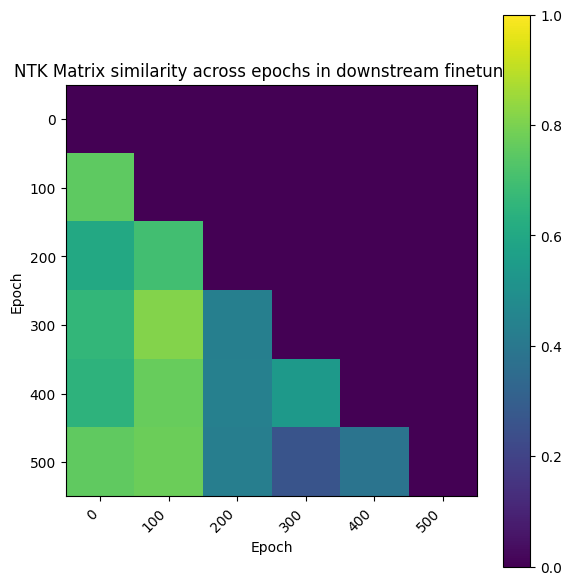

In [ ]:


# Collect gradients and activations eqx.nn.inference_mode 
from tqdm import tqdm
from foundational_ssm.utils.downstream_utils import get_rtt_datasets

cfg = OmegaConf.create({
                        'model':{
                            'input_dim': 72,
                            'context_dim': 4,
                            'ssm_io_dim': 256,
                            'ssm_dim': 128,
                            'ssm_init_diag_blocks': 4,
                            'ssm_num_layers': 2,
                            'output_dim': 2,
                            'rng_seed': 42,
                            'dt_min': 0.001,
                            'dt_max': 0.01,
                            'dropout_p': 0.03,
                            'ssm_dropout_p': 0.01
                        },
                        'optimizer':{
                            'lr': 0.002,
                            'weight_decay': 0.01,
                            'mode': 'muP_SSM'
                        }
                    })

dataset_cfg = OmegaConf.create({
    'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5',
    'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5',
    'batch_size': 64,
    'phase': 'test',
    'skip_timesteps': 56
})
train_data, val_data, data = get_rtt_datasets(dataset_cfg, jr.PRNGKey(0))
loss_fn = mse_single_sample_downstream 

model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_h256_p128_muP_SSM_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

train_trial_subset = {k: v[1:64] for k, v in train_data.items()}
K_w_list = [] 
S = []
skip_timesteps = 56
for epoch, model in tqdm(models.items()):
    inf_model = eqx.nn.inference_mode(model)
    grads_list = []
    batch = train_trial_subset
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    dataset_group_idxs = batch["dataset_group_idx"]

    grads = jax.vmap(eqx.filter_grad(loss_fn), in_axes=(None, None, 0, 0, 0, None, None), axis_name='batch')(model, state, inputs, targets, mask, jr.PRNGKey(0), skip_timesteps)
    grads_list.append(grads)

    opt, opt_state, lr_scheduler, lr_tree = create_optimizer_and_state(model, optimizer_cfg=cfg.optimizer, model_cfg=cfg.model, return_lr_tree=True)
    lr_leaves = [leaf for leaf in jax.tree_util.tree_leaves(eqx.filter(lr_tree, eqx.is_array)) if leaf is not None]
    dicts = [_stack_weighted_grads_to_matrix(g, lr_leaves) for g in grads_list]
    G_w = _dicts_to_matrix(dicts)
    K_w = G_w @ G_w.T
    K_w_list.append(K_w)

S = []
for i, K_w in enumerate(K_w_list):
    _S = []
    for j, K_w2 in enumerate(K_w_list):
        if i >= j:
            _S.append(compute_kernel_similarity(K_w, K_w2))
        else:
            _S.append(0)
    S.append(_S)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(np.array(S), vmax=1, vmin=0)
fig.colorbar(im, ax=ax)
ax.set_title('NTK Matrix similarity across epochs in downstream finetuning')
# Set ticks and labels from `epochs`
ax.set_xticks(list(range(len(epochs))))
ax.set_yticks(list(range(len(epochs))))
ax.set_xticklabels([str(e) for e in epochs])
ax.set_yticklabels([str(e) for e in epochs])
ax.set_xlabel('Epoch')
ax.set_ylabel('Epoch')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()

In [5]:
# Unit tests: small synthetic trees for stackers and similarity functions
def _make_synthetic_tree(batch, shapes, key=0):
    # shapes: dict of path -> shape (without batch)
    rng = jr.PRNGKey(key)
    def make_leaf(shape):
        nonlocal rng
        rng, sub = jr.split(rng)
        return jr.normal(sub, (batch,) + tuple(shape))
    # Build a simple tree: {'a': {'w': arr, 'b': arr}, 'c': arr} maybe with lists too
    # For simplicity, construct a nested dict matching paths like 'encoder.weight' etc
    tree = {}
    for p, s in shapes.items():
        # p like 'encoder.weight' or 'layer[0].bias'
        parts = p.split('.')
        cur = tree
        for i, part in enumerate(parts):
            if i == len(parts) - 1:
                cur[part] = make_leaf(s)
            else:
                if part not in cur:
                    cur[part] = {}
                cur = cur[part]
    return tree

def test_stack_and_similarity():
    shapes = {
        'enc.w': (2, 3),
        'enc.b': (3,),
        'dec.w': (3, 4),
    }
    t1 = _make_synthetic_tree(4, shapes, key=1)
    t2 = _make_synthetic_tree(6, shapes, key=2)
    # Stack into dicts
    dict1 = stack_trees_to_dict([t1], flatten=True)
    dict2 = stack_trees_to_dict([t2], flatten=True)
    assert set(dict1.keys()) == set(dict2.keys())
    # Shapes should match expectations
    meta = get_per_leaf_metadata_from_trees([t1, t2])
    assert meta['enc.w']['shape'] == (2, 3)
    # Matrix shapes
    M1 = stack_trees_to_matrix([t1])
    M2 = stack_trees_to_matrix([t2])
    assert M1.shape[0] == 4 and M2.shape[0] == 6
    # Per-leaf cosine similarity between same trees should be 1 for identical content
    dict1_dup = stack_trees_to_dict([t1], flatten=True)
    cos_sim = compute_per_leaf_cosine_similarity(dict1, dict1_dup)
    for v in cos_sim.values():
        assert jnp.isclose(v, 1.0)
    # Kernel similarity between different random trees: slice dict2 to match dict1 batch size before comparing
    dict2_slice = {k: v[:4] for k, v in dict2.items()}
    ks = compute_per_leaf_kernel_similarity(dict1, dict2_slice)
    for v in ks.values():
        assert jnp.isfinite(v)
    print('All synthetic tests passed.')

# Run test
test_stack_and_similarity()

All synthetic tests passed.
